#IPython Notebook for MyHealthMyFood

Includes Data Cleaning, EDA, Model Training

## Data Ingestion

Ingest the recipe data obtained from Food.com into dataframe for next steps

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import ast

In [2]:
# Data Ingestion: mount google drive and create a df from a csv file
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Recipe.csv')

Mounted at /content/drive


<ipython-input-2-be2b6e7efcba>:5: DtypeWarning: Columns (0,2,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/Recipe.csv')


In [3]:
df.columns


Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions'],
      dtype='object')

## Data Cleaning

In [4]:
# Basic data cleaning
# 1. Drop duplicates
df = df.drop_duplicates()

# 2. Handle missing values
df = df.fillna({
    col: df[col].median() if df[col].dtype in ['int64', 'float64'] else df[col].mode()[0]
    for col in df.columns
})

In [5]:
# 3.filling missing values
df['RecipeIngredientQuantities'] = df['RecipeIngredientQuantities'].fillna('0')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].fillna('unknown ingredient')

# Filling numerical features with 0
df['AggregatedRating'] = df['AggregatedRating'].fillna(0)
df['ReviewCount'] = df['ReviewCount'].fillna(0)

Save necessary data fields for the web app

# Feature Engineering for EDA
Conduct Feature engineering to select the required data for EDA

In [6]:
#Feature Engineering for EDA

df_DR = df.drop(['RecipeId', 'AuthorId', 'CookTime', 'PrepTime', 'DatePublished', 'Description', 'Keywords', 'ReviewCount'], axis=1)


In [7]:
# List of columns to divide by RecipeServings
columns_to_adjust = [
    "FatContent", "SaturatedFatContent", "CholesterolContent",
    "SodiumContent", "CarbohydrateContent", "FiberContent", "SugarContent", "ProteinContent"
]

# Convert columns to numeric, coerce errors to handle any non-numeric entries
for column in columns_to_adjust + ["RecipeServings"]:
    df_DR[column] = pd.to_numeric(df_DR[column], errors='coerce')

# Divide each column by RecipeServings, starting from the second row (index 1)
for column in columns_to_adjust:
    df_DR.loc[1:, column] = df_DR.loc[1:, column] / df_DR.loc[1:, "RecipeServings"]

# Drop the RecipeServings column if no longer needed
df_DR.drop(columns=["RecipeServings"], inplace=True)

In [8]:
df_DR = df_DR.drop(['AuthorName', 'Images', 'AggregatedRating'], axis=1)


In [9]:
# Function to convert PT format to decimal hours
def convert_to_decimal_hours(time_str):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', time_str)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        decimal_hours = hours + minutes / 60
        return round(decimal_hours, 2)  # Rounded to two decimal places
    return None

# Apply the conversion function to the TotalTime column
df_DR['TotalTime'] = df_DR['TotalTime'].apply(convert_to_decimal_hours)

In [10]:
# Columns to check for outliers
columns_to_check = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                    'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
                    'ProteinContent']

# Ensure columns are numeric, coerce errors to handle any non-numeric entries
for column in columns_to_check:
    df_DR[column] = pd.to_numeric(df_DR[column], errors='coerce')

# Calculate IQR and filter outliers, skipping the first row
for column in columns_to_check:
    Q1 = df_DR.loc[1:, column].quantile(0.25)
    Q3 = df_DR.loc[1:, column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out rows with outliers in the specified column, ignoring the first row
    df_DR = df_DR[(df_DR.index == 0) | ((df_DR[column] >= lower_bound) & (df_DR[column] <= upper_bound))]

## EDA

         Ingredient  Frequency
20           "salt"     199780
53         "butter"     136079
29          "sugar"     115852
22          "onion"      87546
56          "water"      84376
28           "eggs"      81186
41      "olive oil"      76724
61          "flour"      62410
5            "milk"      61247
45  "garlic cloves"      59604


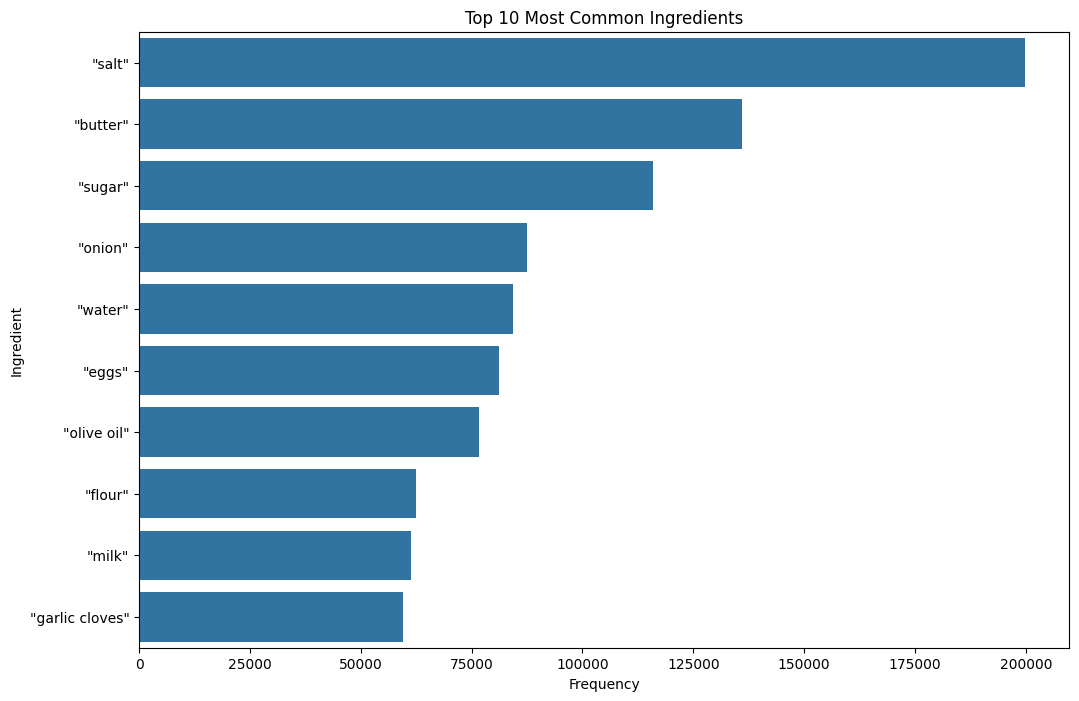

In [11]:
#1. Top Ingredients present in recipe data
# Initialize an empty Counter object
ingredient_counter = Counter()

# Function to clean and extract ingredients
def extract_ingredients(ingredient_str):
    # Remove the 'c(' and ')' characters and split by commas
    ingredient_str = re.sub(r'c\(|\)', '', ingredient_str)
    # Split the string by commas to get individual ingredients
    ingredients = [ingredient.strip() for ingredient in ingredient_str.split(',')]
    return ingredients

# Iterate over each row in the 'RecipeIngredientParts' column
for ingredients in df['RecipeIngredientParts']:
    # Extract and clean ingredients
    ingredient_list = extract_ingredients(ingredients)

    # Update the counter with the ingredients in this row
    ingredient_counter.update(ingredient_list)

# Convert the counter object to a DataFrame for better readability
ingredient_frequency_df = pd.DataFrame(ingredient_counter.items(), columns=['Ingredient', 'Frequency'])

# Sort the DataFrame by frequency in descending order
ingredient_frequency_df = ingredient_frequency_df.sort_values(by='Frequency', ascending=False)

# Display the top 10 most frequent ingredients
print(ingredient_frequency_df.head(10))

# Plotting the top 10 most common ingredients
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Ingredient', data=ingredient_frequency_df.head(10))
plt.title('Top 10 Most Common Ingredients')
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.show()

In [12]:
# Data Reduction for RecipeCategory
unique_categories = df_DR['RecipeCategory'].unique()
print(unique_categories)

['Frozen Desserts' 'Vegetable' 'Pie' 'Dessert' 'Beverages' 'Sauces' 'Stew'
 'Weeknight' 'Whole Chicken' 'Cheesecake' 'Free Of...' 'Brazilian'
 'Breads' 'Bar Cookie' 'Brown Rice' 'Oranges' 'Low Protein'
 'Chicken Breast' 'Potato' 'Very Low Carbs' 'Chicken' 'Scones'
 'Drop Cookies' 'Beans' 'Punch Beverage' 'Yeast Breads' 'Lunch/Snacks'
 'Pineapple' 'Chicken Livers' '< 60 Mins' '< 30 Mins' 'Savory Pies'
 'Poultry' 'Quick Breads' 'Healthy' 'Pork' 'Apple' 'Cheese' 'Crab'
 'Soy/Tofu' 'Cauliflower' 'White Rice' 'Chowders' 'German' 'European'
 'Breakfast' 'Meat' 'Manicotti' 'Onions' 'New Zealand'
 'Chicken Thigh & Leg' 'Indonesian' 'Greek' 'Corn' 'Smoothies'
 'Long Grain Rice' 'Dutch' 'Gelatin' 'Lamb/Sheep' 'Fruit' 'Berries'
 'Peppers' 'Candy' 'Spanish' 'Low Cholesterol' 'Shakes' 'Lentil'
 'Short Grain Rice' 'One Dish Meal' 'Spicy' '< 15 Mins' 'Mexican' 'Thai'
 'Cajun' 'Sourdough Breads' 'Salad Dressings' 'Oven' 'Rice' 'Microwave'
 'Asian' 'Tuna' 'Jellies' 'Beef Organ Meats' 'Swiss' 'Papaya' '

In [13]:
# Define the categories to keep
categories_to_keep = ['Breakfast', 'Brunch', 'Lunch/Snacks', 'Dessert']

# Filter out the rows with the specified categories or assign the remaining categories randomly
df_DR['RecipeCategory'] = df_DR['RecipeCategory'].apply(
    lambda x: x if x in categories_to_keep else np.random.choice(['Lunch/Snacks', 'Dinner'])
)

# 2. Remove outlier entries
# Define a list of common patterns to identify erroneous entries (e.g., URLs, image paths)
outlier_patterns = ['http', 'q_95', 'c_fit', 'food/image', 'img/recipes']
# Filter rows where RecipeCategory does not contain any outlier pattern
df_DR = df_DR[~df_DR['RecipeCategory'].str.contains('|'.join(outlier_patterns), case=False, na=False)]

# View the cleaned DataFrame
print(df_DR['RecipeCategory'].unique())  # Check unique categories after cleaning
print(df_DR.shape)  # Check the shape to confirm rows were removed

['Dinner' 'Lunch/Snacks' 'Dessert' 'Breakfast' 'Brunch']
(274669, 16)


<ipython-input-14-ae376a7c65e5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


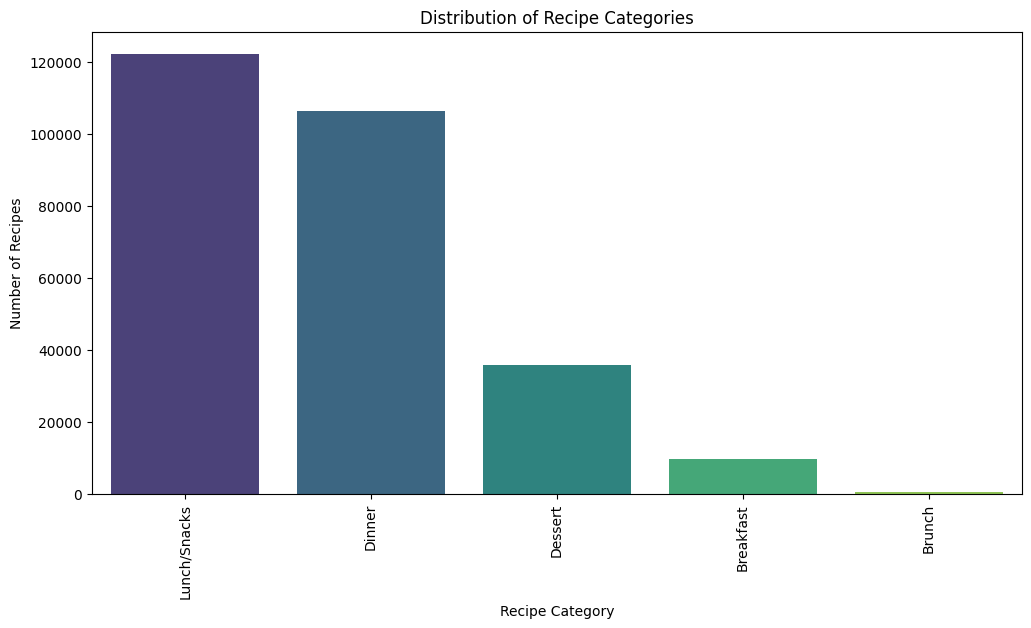

In [14]:
#Distribution of Recipe Categories

# Count the number of recipes per category
category_counts = df_DR['RecipeCategory'].value_counts().head(10)


# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of Recipe Categories')
plt.xlabel('Recipe Category')
plt.ylabel('Number of Recipes')
plt.show()

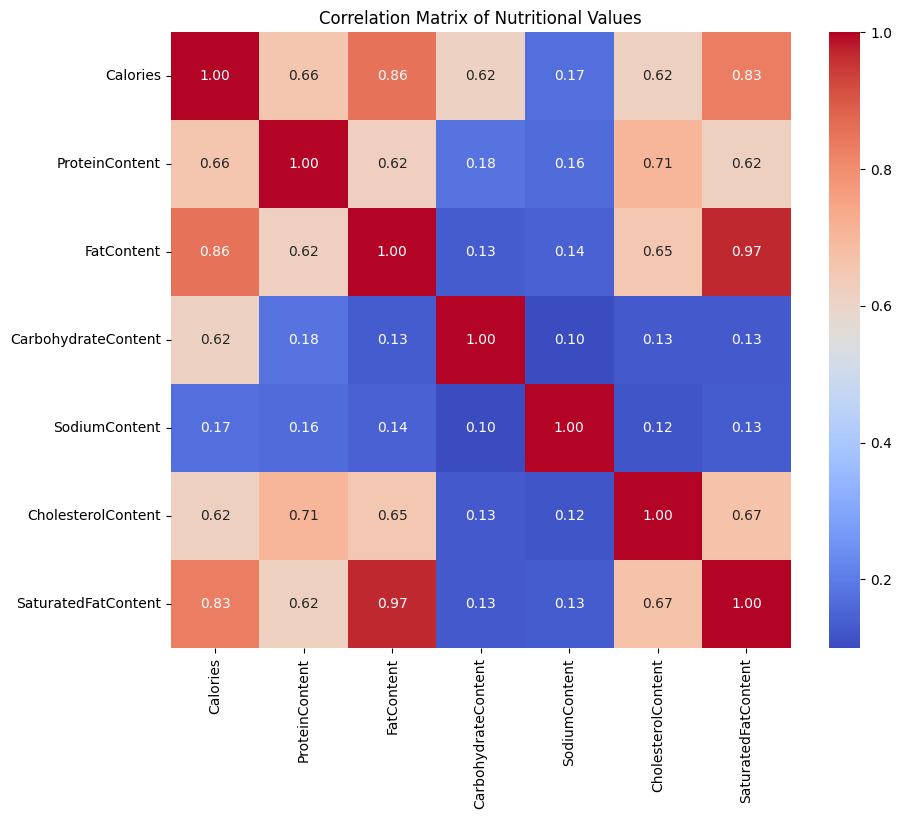

In [ ]:
#Correlation Plot

# Define the list of nutritional columns, e.g., calories, protein, fat, etc.
nutritional_columns = ['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent', 'SodiumContent', 'CholesterolContent', 'SaturatedFatContent']

# Filter out non-numeric columns, keeping only the numeric ones
df_nutritional = df_DR[nutritional_columns].apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values that result from non-numeric entries
df_nutritional = df_nutritional.dropna()

# Compute the correlation matrix
corr_matrix = df_nutritional.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Nutritional Values')
plt.show()

## Feature Selection & Train Test Split

In [15]:
#Loan required packages
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import joblib

In [16]:
#Step 1: Data Massaging
# Select relevant nutrient features
nutrient_features = ['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent', 'SodiumContent', 'CholesterolContent', 'SaturatedFatContent','FiberContent', 'SugarContent']

# Convert nutrient features to numeric
df_DR[nutrient_features] = df_DR[nutrient_features].apply(pd.to_numeric, errors='coerce')

# Fill missing values in nutrient features with the mean
df_DR[nutrient_features] = df_DR[nutrient_features].fillna(df_DR[nutrient_features].mean())

# Step 1: Normalize nutrient data
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_DR[nutrient_features]), columns=nutrient_features)

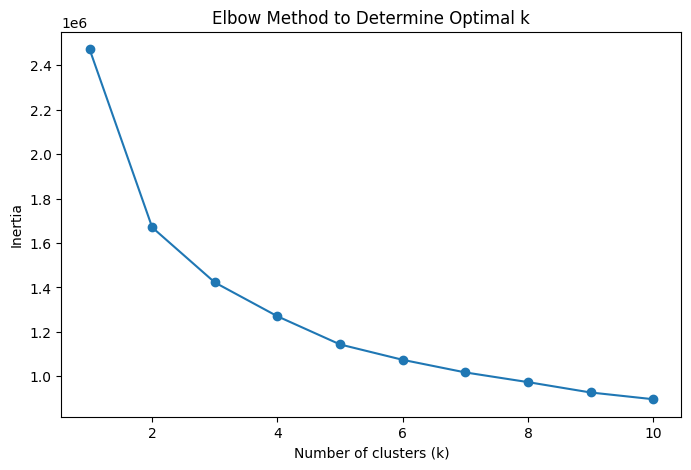

In [17]:
# Step 2: Apply K-means clustering
# Store the sum of squared distances for each number of clusters
inertia = []
K = range(1, 11)  # Testing k from 1 to 10

# Fit KMeans for each number of clusters and calculate inertia
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_norm)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_DR['Cluster'] = kmeans.fit_predict(df_norm)

In [26]:
#Step 3:  Train Random Forest Classifier and Cosine Similarity (Content Based) to predict clusters
X = df_norm
y = df_DR['Cluster']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the Random Forest classifier on the training data
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data to calculate accuracy
y_pred = rf_classifier.predict(X_test)
classification_accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {classification_accuracy}")


Classification accuracy: 0.9734954672880184


In [28]:
# Remove unnecessary attributes to reduce model size
rf_classifier.oob_score_ = None
rf_classifier.estimators_ = rf_classifier.estimators_[:10]

In [23]:
#Step 4: Recommend food with cosine
def recommend_food(input_data, gender, weight, height, age, health_condition=None, wellness_goal=None):
    # Define weights based on the nutrient features
    weights = np.ones(len(nutrient_features))

    # Modify weights based on health condition
    health_conditions = ["Diabetic", "High Blood Pressure", "High Cholesterol"]
    if health_condition in health_conditions:
        if 'SugarContent' in nutrient_features and health_condition == "Diabetic":
            weights[nutrient_features.index('SugarContent')] = 0.5
        if 'SodiumContent' in nutrient_features and health_condition == "High Blood Pressure":
            weights[nutrient_features.index('SodiumContent')] = 0.5
        if 'CholesterolContent' in nutrient_features and health_condition == "High Cholesterol":
            weights[nutrient_features.index('CholesterolContent')] = 0.5
        # If any health condition is present, ignore wellness goal adjustments
        wellness_goal = None

    # Modify weights based on wellness goal if no health condition applies
    if wellness_goal is not None:
        if wellness_goal == "Lose Fat":
            if 'FatContent' in nutrient_features:
                weights[nutrient_features.index('FatContent')] = 0.5
            if 'Calories' in nutrient_features:
                weights[nutrient_features.index('Calories')] = 0.5
        elif wellness_goal == "Gain Muscle":
            if 'ProteinContent' in nutrient_features:
                weights[nutrient_features.index('ProteinContent')] = 0.5

    # Apply weights to input data
    weighted_input = input_data * weights

    # Predict the cluster using the Random Forest classifier
    predicted_cluster = rf_classifier.predict([weighted_input])[0]

    # Filter the dataset for the predicted cluster
    cluster_data = df_DR[df_DR['Cluster'] == predicted_cluster][nutrient_features]

    # Normalize the input and cluster data
    norm_input = scaler.transform([weighted_input])
    norm_cluster_data = scaler.transform(cluster_data)

    # Calculate cosine similarity between input and items in the predicted cluster
    similarities = cosine_similarity(norm_input, norm_cluster_data).flatten()
    cluster_data['Similarity'] = similarities

    # Get the top N recommendations based on cosine similarity
    top_recommendations = cluster_data.sort_values(by="Similarity", ascending=False).head(10)
    recommended_food_names = df.loc[top_recommendations.index, 'Name']

    return recommended_food_names

In [30]:
# Save the models as .pkl files
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('rf_classifier.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [49]:
df_DR.to_csv('df_DR.csv', index=False)

# Testing the Food Recommendation Function

In [50]:
# Step 1: Calculate Calorie Need Function
def calculate_caloric_needs(gender, weight, height, age):
    if gender == "Female":
        return 655 + (9.6 * weight) + (1.8 * height) - (4.7 * age)
    elif gender == "Male":
        return 66 + (13.7 * weight) + (5 * height) - (6.8 * age)
    else:
        raise ValueError("Gender not recognized. Use 'Male' or 'Female'.")

In [62]:
# Step 2: Define Nutrient Requirement based on Health Condition
def define_nutrient_intake(Calories, health_condition, weight):
    nutrient_requirements = {
        'Calories': Calories,
        'Protein': 0,
        'Fats': 0,
        'Carbohydrates': 0,
        'Sodium': 2000,
        'Cholesterol': 200,
        'SaturatedFats': 0,
        'SugarContent': 0,
        'FibreContent': 0
    }

    if health_condition == "Diabetic":
        nutrient_requirements['Protein'] = 0.8 * weight  # g/kg for protein
        nutrient_requirements['Fats'] = 0.25 * Calories  # x Daily Calorie Intake for fats
        nutrient_requirements['Carbohydrates'] = 0.6 * Calories  # x Daily Calorie Intake for carbs
        nutrient_requirements['Sodium'] = 2000  # mg
    elif health_condition == "High Blood Pressure":
        nutrient_requirements['Protein'] = 0.5 * Calories / 4  # 0.5x Daily Calorie Intake for protein
        nutrient_requirements['Fats'] = 0.25 * Calories / 9  # 0.25x Daily Calorie Intake for Fats
        nutrient_requirements['Carbohydrates'] = 0.6 * Calories / 4  # 0.6x Daily Calorie Intake for Carbs
        nutrient_requirements['Sodium'] = 1000  # mg
        nutrient_requirements['Cholesterol'] = 300  # mg
    elif health_condition == "High Cholesterol":
        nutrient_requirements['Protein'] = 0.5 * Calories / 4  # Recommended protein intake
        nutrient_requirements['Fats'] = Calories * 0.15 / 9  # Minimum fat intake
        nutrient_requirements['SaturatedFats'] = Calories * 0.10 / 9  # Max saturated fat
        # No specific recommendations for Sodium and Cholesterol here
    else:
        print("Health condition not recognized. Using default nutrient requirements.")

    return nutrient_requirements


In [63]:
# Step 3: Input Data Calculation Function
def calculate_nutrient_intake(gender, weight, height, age, health_condition):
    # Calculate daily calories based on user details
    daily_calories = calculate_caloric_needs(gender, weight, height, age)

    # Calculate nutrient intake based on health conditions
    nutrient_requirements = define_nutrient_intake(daily_calories, health_condition, weight)

    # Prepare input data for recommendations
    input_data = np.array([
        nutrient_requirements['Calories'],
        nutrient_requirements['Protein'],
        nutrient_requirements['Fats'],
        nutrient_requirements['Carbohydrates'],
        nutrient_requirements['Sodium'],
        nutrient_requirements['Cholesterol'],
        nutrient_requirements['SaturatedFats'],
        nutrient_requirements['SugarContent'],
        nutrient_requirements['FibreContent']
    ])

    return input_data

In [64]:
# Load the trained models from .pkl files
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('rf_classifier.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

# Nutrient features defined
nutrient_features = ['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent', 'SodiumContent', 'CholesterolContent', 'SaturatedFatContent', "FiberContent", "SugarContent"]

# Recommend food with cosine similarity
def recommend_food(input_data, health_condition=None):
    # Define weights based on the nutrient features
    weights = np.ones(len(nutrient_features))
    # Ensure column names are stripped of whitespace
    df_DR.columns = df_DR.columns.str.strip()

    # Modify weights based on health condition
    health_conditions = ["Diabetic", "High Blood Pressure", "High Cholesterol"]
    if health_condition in health_conditions:
        if 'SugarContent' in nutrient_features and health_condition == "Diabetic":
            weights[nutrient_features.index('SugarContent')] = 0.05
        if 'SodiumContent' in nutrient_features and health_condition == "High Blood Pressure":
            weights[nutrient_features.index('SodiumContent')] = 0.05
        if 'CholesterolContent' in nutrient_features and health_condition == "High Cholesterol":
            weights[nutrient_features.index('CholesterolContent')] = 0.05
        wellness_goal = None  # Ignore wellness goal adjustments if health condition is present

    # Apply weights to input data
    weighted_input = input_data * weights

    # Predict the cluster using the Random Forest classifier
    predicted_cluster = rf_classifier.predict([weighted_input])[0]

    # Convert weighted_input to DataFrame for prediction
    input_df = pd.DataFrame([weighted_input], columns=nutrient_features)

    cluster_data = df_DR[df_DR['Cluster'] == predicted_cluster][nutrient_features]

    # Exclude desserts if the health condition is diabetic
    if health_condition == "Diabetic":
        cluster_data = cluster_data[df_DR['RecipeCategory'] != 'Dessert']

    # Meal categories to recommend from
    meal_categories = ['Breakfast', 'Brunch', 'Lunch/Snacks', 'Dinner', 'Dessert']
    recommendations = {}

    # Normalize the input and cluster data
    norm_input = scaler.transform([weighted_input])
    norm_cluster_data = scaler.transform(cluster_data)

    for category in meal_categories:
        # Filter the cluster data for the specific meal category
        meal_data = df_DR[df_DR['RecipeCategory'] == category]

        # Check if there are available items for the meal category
        if not meal_data.empty:
            # Normalize the input for this category
            norm_input = scaler.transform(input_df)


    # Calculate cosine similarity between input and items in the predicted cluster
    similarities = cosine_similarity(norm_input, norm_cluster_data).flatten()
    cluster_data['Similarity'] = similarities

    # Get the top N recommendations based on cosine similarity
    top_recommendations = cluster_data.sort_values(by="Similarity", ascending=False).head(10)
    # Get recommended food names and their ingredients
    recommended_food_names = df.loc[top_recommendations.index, 'Name']
    recommended_Categories = df_DR.loc[top_recommendations.index, 'RecipeCategory']

    # Create a list of tuples with food names and ingredients
    recommendations = list(zip(recommended_food_names, recommended_Categories))

    return recommendations

In [65]:
# User Inputs
gender = "Female"  # User input for gender
weight = 60  # kg
height = 172  # cm
age = 30  # years
health_condition = "High Blood Pressure"

# Calculate input data based on user details
input_data = calculate_nutrient_intake(gender, weight, height, age, health_condition)

# Get food recommendations
recommendations = recommend_food(input_data, health_condition)

# Print recommended food items along with their RecipeCategory
for food, category in recommendations:
    print(f"Recommended food item: {food}\nRecipe Category: {category}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Recommended food item: Easy Goulash
Recipe Category: Dinner

Recommended food item: Chicken Soup With Rice
Recipe Category: Dinner

Recommended food item: Ritzy's Mushroom Chicken Noodle Soup
Recipe Category: Lunch/Snacks

Recommended food item: Italian Chicken Sandwich
Recipe Category: Lunch/Snacks

Recommended food item: Roasted Chicken Pasta Salad
Recipe Category: Dinner

Recommended food item: Hamburgers Deluxe
Recipe Category: Dinner

Recommended food item: Chicken Alfredo and Rice Casserole
Recipe Category: Dinner

Recommended food item: Beef &amp; Pasta
Recipe Category: Dinner

Recommended food item: Meatball &amp; Rice Soup
Recipe Category: Dinner

Recommended food item: Kraft One-Dish Italian Fish
Recipe Category: Dinner



In [ ]:
# Data Ingestion: mount google drive and create a df from a csv file
#from google.colab import drive
#drive.mount('/content/drive')

#df_1 = pd.read_csv('/content/drive/My Drive/df_MHMF.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-505e5ec4b178>:5: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv('/content/drive/My Drive/df_MHMF.csv')


In [ ]:
# Data Ingestion: mount google drive and create a df from a csv file
from google.colab import drive
drive.mount('/content/drive')

df_1 = pd.read_csv('/content/drive/My Drive/df_MFMH.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
from google.colab import files

# Keep 20% of the DataFrame
df_sample = df_DR.sample(frac=0.10, random_state=42)

In [80]:
# Replace these characters in the "Name" column
df_sample['Name'] = df_sample['Name'].str.replace('&', '', regex=False)
df_sample['Name'] = df_sample['Name'].str.replace('quot', '', regex=False)
df_sample['Name'] = df_sample['Name'].str.replace(';', '', regex=False)

In [81]:
# Remove rows containing "beer" or "drink" in the 'Name' column
df_sample = df_sample[~df_sample['Name'].str.contains('Beer', case=False, na=False)]

In [82]:
# Download the sample DataFrame as a CSV file
df_sample.to_csv('df_sample.csv', index=False)
files.download('df_sample.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>